100%|██████████| 9.91M/9.91M [01:59<00:00, 83.2kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 666kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.70MB/s]


Epoch [1/5], Loss: 0.1529
Epoch [2/5], Loss: 0.0443
Epoch [3/5], Loss: 0.0306
Epoch [4/5], Loss: 0.0234
Epoch [5/5], Loss: 0.0165
Test Accuracy (CNN): 99.17%
Test Accuracy (KNN): 97.05%
Test Accuracy (SVM): 93.59%
Test Accuracy (RFC): 97.02%


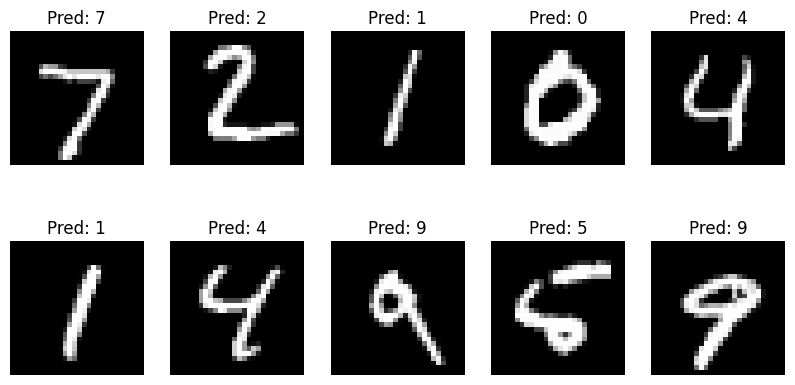

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Define transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing Loop
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy (CNN): {100 * correct / total:.2f}%")

# Extract features for ML models
def extract_features(dataset):
    features, labels = [], []
    for img, label in dataset:
        features.append(img.numpy().flatten())
        labels.append(label)
    return np.array(features), np.array(labels)

X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(test_dataset)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(f"Test Accuracy (KNN): {accuracy_score(y_test, knn_pred) * 100:.2f}%")

# Support Vector Machine
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print(f"Test Accuracy (SVM): {accuracy_score(y_test, svm_pred) * 100:.2f}%")

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print(f"Test Accuracy (RFC): {accuracy_score(y_test, rfc_pred) * 100:.2f}%")

# Visualizing Predictions
sample_images, sample_labels = next(iter(test_loader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
predictions = model(sample_images)
_, predicted_labels = torch.max(predictions, 1)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i].cpu().squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted_labels[i].item()}")
    ax.axis('off')
plt.show()